# RNN

## 1. 필요라이브러리 임포트

In [3]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# train, test 분리
from sklearn.model_selection import train_test_split

# kiwi 형태소 분석기
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords

import os
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(SEED)

활용 데이터: klue_tc<br>
- 7개의 토픽 중 정치, 스포츠, 경제 토픽의 문장들만 선별→ 분류과제로 변환
- 스포츠 토픽: 0(6933개), 정치 토픽: 1(6751개), 경제 토픽: 2(6222)
- 뉴스데이터의 특성상, 한자가 포함되어있기 때문에 <b>hanja 라이브러리를 이용하여 한글로 변환</b>

In [4]:
df = pd.read_csv('/home/xogns5037/딥러닝코딩스터디/RNN/Tensorflow_RNN/klue_tc_tri.csv', index_col=0)
df.head()
# 0이 스포츠, 1이 정치, 2가 경제

,new_title,topic_idx
43,김영남 우리 민족 위상 과시…뜨거운 분위기 이어가길,1
48,적극행정 추진전략 및 성과공유대회 참석한 이낙연 총리,1
49,박대통령 한일 합의에 소녀상 언급없어…선동하면 안돼,1
50,민주 국회의원 재보선 4곳 후보 공모에 7명 신청,1
52,박찬호 현진이 10승 하니깐 생각이 나는데…,0


## 1. 필요한 문자(한글, 알파벳, 숫자, 특수부호 등)만 선택

In [5]:
print(f'전처리 전 데이터 샘플의 개수:{len(df)}')
df.drop_duplicates(subset = ['new_title'], inplace=True) # 중복 제거
# 이모지 제거 위해 한글, 알파벳, 공백이 아닌 것은 모두 제거
df['new_title']=df['new_title'].str.replace(pat=r'[^ㄱ-힣|a-zA-Z| ]+', repl= r' ', regex=True)
df['new_title'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
df = df.dropna(how='any') # Null 값 제거
print(f'전처리 후 데이터 샘플의 개수:{len(df)}')

전처리 전 데이터 샘플의 개수:19906
전처리 후 데이터 샘플의 개수:19906


## 2. kiwi로 형태소 분석하기 + 기본형 복원

In [6]:
# kiwi 사용하기
kiwi = Kiwi()
kiwi.prepare() # 전처리 위한 준비
stopwords = Stopwords() # 불용어 사전 불러오기

In [7]:
def kiwi_preprocess(sen):
    tokens = kiwi.tokenize(sen, stopwords = stopwords) # 형태소분석진행
    morph_list = [word + ('다' if tag.startswith('V') else '') for word, tag, _, _ in tokens] # 동사, 형용사인 경우 원형 복원
    return " ".join(morph_list)

In [8]:
# 데이터 프레임에 전처리한 결과 추가
str_list = df['new_title'].tolist()
new_list = []
for s in str_list:
    new_list.append(kiwi_preprocess(s))
df['tokenized'] = new_list

In [9]:
df.head(11) # 원본 데이터와 비교

,new_title,topic_idx,tokenized
43,김영남 우리 민족 위상 과시 뜨거운 분위기 이어가길,1,김영남 민족 위상 과시 뜨겁다 분위기 잇다 가다 ᆯ
48,적극행정 추진전략 및 성과공유대회 참석한 이낙연 총리,1,적극 행정 추진 전략 및 성과 공유 대회 참석 이낙연 총리
49,박대통령 한일 합의에 소녀상 언급없어 선동하면 안돼,1,박 대통령 한일 합의 소녀상 언급 선동 안
50,민주 국회의원 재보선 곳 후보 공모에 명 신청,1,민주 국회 의원 재보선 곳 후보 공모 명 신청
52,박찬호 현진이 승 하니깐 생각이 나는데,0,박찬호 현진이 승 니깐 생각 나다 는데
53,현행 헌법과 다른 점은 지방자치 경제민주화 개념 강화,1,현행 헌법 다른 점 지방 자치 경제 민주 개념 강화
54,고군분투 시즌 서재덕 MVP 덕큐리로 활짝 웃다종합,0,고군분투 시즌 서재 덕 MVP 덕큐리 활짝 웃다 종합
55,트럼프 유조선 공격 사소한 일 이란과 충돌우려 속 수위조절,1,트럼프 유조선 공격 사소 이란 충돌 우려 속 수위 조절
56,이희호 여사 청경호 일로 만료 당분간 경호 유지될 듯,1,이희호 여사 청 경호 만료 당분간 경호 유지 듯
57,통일농구 오늘은 친선 남북대결 김정은 관전 가능성,1,통일 농구 오늘 친선 남북 대결 김정은 관전 가능


In [10]:
# train, test 데이터 분리
train_data, test_data = train_test_split(df, test_size = 0.2, random_state = 42, stratify=df['topic_idx'])
print('훈련용 데이터의 개수 :', len(train_data))
print('테스트용 데이터의 개수 :', len(test_data))

훈련용 데이터의 개수 : 15924
테스트용 데이터의 개수 : 3982


## 3. tensorflow 이용한 임베딩

### 1) 문자열 길이 분포 확인
- 문자열의 최대길이(maxlen)를 정하기 위해 필요한 과정임

스포츠 기사제목의 중위값 길이 : 9.0
정치 기사제목의 중위값 길이 : 9.0
경제 기사제목의 중위값 길이 : 9.0


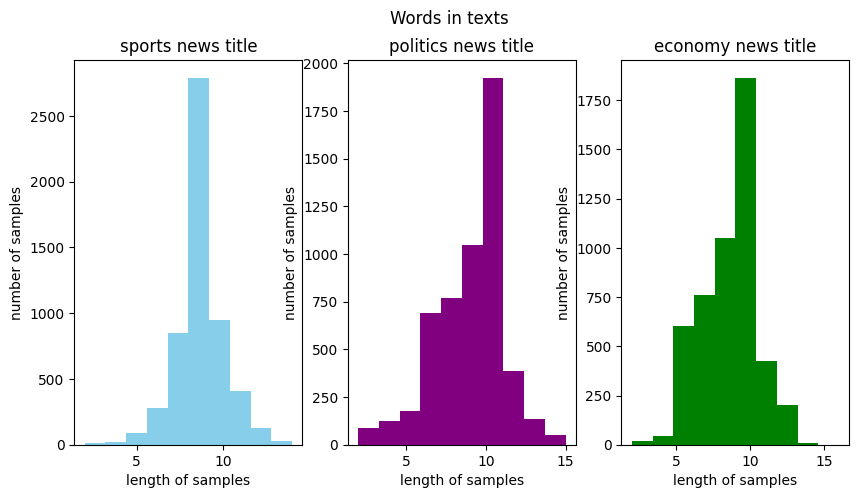

In [11]:
fig,(ax1,ax2, ax3) = plt.subplots(1,3,figsize=(10,5))
text_len = train_data[train_data['topic_idx']==0]['tokenized'].map(lambda x: len(x.split(' ')))
ax1.hist(text_len, color='skyblue')
ax1.set_title('sports news title')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('스포츠 기사제목의 중위값 길이 :', np.median(text_len))

text_len = train_data[train_data['topic_idx']==1]['tokenized'].map(lambda x: len(x.split(' ')))
ax2.hist(text_len, color='purple')
ax2.set_title('politics news title')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('정치 기사제목의 중위값 길이 :', np.median(text_len))

text_len = train_data[train_data['topic_idx']==2]['tokenized'].map(lambda x: len(x.split(' ')))
ax3.hist(text_len, color='green')
ax3.set_title('economy news title')
fig.suptitle('Words in texts')
ax3.set_xlabel('length of samples')
ax3.set_ylabel('number of samples')
print('경제 기사제목의 중위값 길이 :', np.median(text_len))
plt.show()
#넉넉잡아 16으로 하기로 함

In [12]:
# array로 변환
X_train = train_data['tokenized'].values
y_train = train_data['topic_idx'].values
X_test= test_data['tokenized'].values
y_test = test_data['topic_idx'].values

In [13]:
X_train[:5]

array(['반기문 북 대화 향하다 길 다시 찾다 종합', '축구 투자 중 재벌 사정 칼바람 건재 이유',
       '월드컵 태극 전사 행운 달러 장 선물 왜', '원 달러 환율 상승 반등 마감',
       '출국 많다 입국 적다 분기 여행 수지 적자 억불 최대 종합'], dtype=object)

In [14]:
X_train.shape

(15924,)

### + 단어빈도 확인

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt)) # GPU 메모리가 여유 있으면 상관 없지만 부족할 경우 제거하는 것이 좋음
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 15046
등장 빈도가 1번 이하인 희귀 단어의 수: 6075
단어 집합에서 희귀 단어의 비율: 40.37617971553901
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.368963458924552


### 2) 고유한 인덱스 부여 + 패딩
credits: https://han-py.tistory.com/284

In [16]:
# 가장 빈도가 높은 15047개의 단어만 선택하도록 하는 Tokenizer 객체
tokenizer = Tokenizer(num_words=15047, oov_token="<OOV>") #이후 test set에서 out of vocab에 대한 처리가능

# 그에 맞게 단어 인덱스를 구축
tokenizer.fit_on_texts(X_train) # 학습 데이터에 대해서만 fit_on_texts를 해줘야함

# 고유한 사전으로 저장
word_dic = tokenizer.word_index

# 사전의 크기 측정
print(f'사전의 크기: {len(word_dic)}')

# 사전의 크기를 max_features 변수에 저장
max_features = len(word_dic)

# '<OOV>': 1 포함하여 총 15047

사전의 크기: 15047


In [17]:
word_dic

{'<OOV>': 1,
 '종합': 2,
 '대통령': 3,
 '북': 4,
 '억': 5,
 '박': 6,
 '서': 7,
 '감독': 8,
 '문': 9,
 '전': 10,
 '프로': 11,
 '농구': 12,
 '경기': 13,
 '천': 14,
 '대표': 15,
 '주': 16,
 '대': 17,
 '팀': 18,
 '위': 19,
 '분기': 20,
 '첫': 21,
 '만': 22,
 '정상': 23,
 '배구': 24,
 '투자': 25,
 '한국': 26,
 '축구': 27,
 '보': 28,
 '당': 29,
 '류현진': 30,
 '여자': 31,
 '차': 32,
 '회담': 33,
 '안': 34,
 '월드컵': 35,
 '여': 36,
 '청': 37,
 '시즌': 38,
 '선수': 39,
 '월': 40,
 '국회': 41,
 '김정은': 42,
 '금융': 43,
 '연승': 44,
 '남북': 45,
 '일': 46,
 '작년': 47,
 '코스피': 48,
 'sk': 49,
 '조': 50,
 '시장': 51,
 '리그': 52,
 '점': 53,
 '정부': 54,
 '승': 55,
 '골': 56,
 'mlb': 57,
 '꺾다': 58,
 '나': 59,
 '북한': 60,
 '아시안': 61,
 '연속': 62,
 '권': 63,
 '게임': 64,
 '경제': 65,
 '째': 66,
 '영업익': 67,
 '홈런': 68,
 '평양': 69,
 '계약': 70,
 '손흥민': 71,
 '개': 72,
 '무': 73,
 '기업': 74,
 '실적': 75,
 '가능': 76,
 '원': 77,
 '그래픽': 78,
 '여야': 79,
 'kt': 80,
 '미': 81,
 '금리': 82,
 '특징': 83,
 '결정': 84,
 '올해': 85,
 '호': 86,
 '상승': 87,
 '달러': 88,
 '우승': 89,
 '올림픽': 90,
 '대회': 91,
 '대출': 92,
 '보다': 93,
 '최고'

In [18]:
len(word_dic)

15047

In [19]:
# 최대 길이 설정
max_len = 16

# 각 형태소를 인덱스로 변환
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# 패딩
# default: padding = 'pre' / 'pre'는 앞에 0으로 채움, 'post'는 뒤에 0으로 채움
# default: truncating = 'pre' / 'pre'는 앞을 자르고, 'post'는 뒤를 자름
# max_len을 넘어가면 짜르고, 안넘으면 0으로 채움
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len) 

#### 패딩에 대해서는 하려는 task를 고려하는 것이 필요함<br>
앞부분에 패딩을 넣어주는 것이 일반적이나 아래의 경우 고려할 여지가 있음:
- **번역 등의 과제를 수행한다면(encoder-decoder형태의 구조가 필요한) <eos>(end of sentence)토큰이 나올 때까지 생성하기 때문에 앞부분에 패딩을 넣어주는 것이 좋음**
- 이와 달리, **생성이 필요하지않고, 연산이 복잡한 경우 뒷부분에 패딩을 넣어주는 것이 좋음**

In [20]:
X_train[3]

array([ 77,  88, 279,  87, 603, 268,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

In [21]:
X_train.shape #학습데이터 15924개 16차원의 벡터로 표현됨

(15924, 16)

y변수에 대한 원-핫 인코딩<br>
loss function을 'categorical_crossentropy'로 사용해야함<br>
원-핫 인코딩을 하지 않았다면 'sparse_categorical_crossentropy'를 사용함

In [22]:
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train) # one hot encoding = [0, 0, 1]
y_test_one_hot = to_categorical(y_test)

In [23]:
y_train_one_hot[:3]

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

## 4. tensorflow활용 RNN모델 구축

- return_sequences: 모든 시점의 은닉상태를 출력
- return_state: TRUE로 설정하는 경우 마지막 시점의 은닉상태를 함께 출력

In [24]:
# simpleRNN1
model = models.Sequential()
model.add(layers.Embedding(max_features+1, 32, input_length=max_len))
model.add(layers.Masking(mask_value = 0.0)) # 패딩에 해당하는 인덱스는 0은 연산에서 제외(학습을 하지 않음)
model.add(layers.SimpleRNN(units=32, input_dim=32)) # units: RNN hidden state 출력의 차원수
model.add(layers.Dense(units=16, input_dim=32, activation='tanh'))
model.add(layers.Dense(units=3, input_dim=16, activation='softmax'))
model.summary()
# tensorflow에서는 input_dim을 지정해주지 않아도 알아서 처리해줌

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 32)            481536    
                                                                 
 masking (Masking)           (None, 16, 32)            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 484195 (1.85 MB)
Trainable params: 484195 (1.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-07-27 10:46:04.796572: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [25]:
# simpleRNN2 : masking layer 제거 예시
model = models.Sequential()
model.add(layers.Embedding(max_features+1, 32, input_length=max_len))
# model.add(layers.Masking(mask_value = 0.0)) 
model.add(layers.SimpleRNN(units=32, input_dim=32)) 
model.add(layers.Dense(units=16, input_dim=32, activation='tanh'))
model.add(layers.Dense(units=3, input_dim=16, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 16, 32)            481536    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                                 
Total params: 484195 (1.85 MB)
Trainable params: 484195 (1.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


stackedRNN

In [26]:
#stackedRNN
model2 = models.Sequential()
model2.add(layers.Embedding(max_features+1, 32, input_length=max_len))
# 다음 RNN레이어에 hidden state값을 입력값으로 넣어줘야하기 때문에 return_sequences = True로 설정
model2.add(layers.SimpleRNN(units=32, input_dim=32, return_sequences=True))
model2.add(layers.SimpleRNN(units=16, input_dim=32)) 
model2.add(layers.Dense(units=16, input_dim=16, activation='tanh'))
model2.add(layers.Dense(units=3, input_dim=16, activation='softmax'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 16, 32)            481536    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 16, 32)            2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 16)                784       
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 3)                 51        
                                                                 
Total params: 484723 (1.85 MB)
Trainable params: 484723 (1.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
#bidirectionalRNN: 양방향 RNN
model3 = models.Sequential()
model3.add(layers.Embedding(max_features+1, 32, input_length=max_len))
#단방향 RNN에 비해 파라미터의 수가 2배가 됨
model3.add(layers.Bidirectional(layers.SimpleRNN(32, return_sequences = True))) 
model3.add(layers.SimpleRNN(units=16, input_dim=64)) 
model3.add(layers.Dense(units=16, input_dim=16, activation='tanh')) # -1 ~ 1사이값으로 변환 + 차원축소
model3.add(layers.Dense(units=3, input_dim=16, activation='softmax'))
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 16, 32)            481536    
                                                                 
 bidirectional_1 (Bidirecti  (None, 16, 64)            4160      
 onal)                                                           
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 16)                1296      
                                                                 
 dense_8 (Dense)             (None, 16)                272       
                                                                 
 dense_9 (Dense)             (None, 3)                 51        
                                                                 
Total params: 487315 (1.86 MB)
Trainable params: 487315 (1.86 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [30]:
from tensorflow.keras.optimizers import RMSprop
model3.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
history = model3.fit(X_train, y_train_one_hot, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10


112/112 [==============================] - 3s 16ms/step - loss: 0.3676 - accuracy: 0.8613 - val_loss: 0.1541 - val_accuracy: 0.9473
Epoch 2/10
112/112 [==============================] - 2s 14ms/step - loss: 0.0632 - accuracy: 0.9828 - val_loss: 0.1194 - val_accuracy: 0.9579
Epoch 3/10
112/112 [==============================] - 2s 15ms/step - loss: 0.0277 - accuracy: 0.9927 - val_loss: 0.1336 - val_accuracy: 0.9623
Epoch 4/10
112/112 [==============================] - 2s 14ms/step - loss: 0.0155 - accuracy: 0.9960 - val_loss: 0.1700 - val_accuracy: 0.9573
Epoch 5/10
112/112 [==============================] - 2s 15ms/step - loss: 0.0093 - accuracy: 0.9973 - val_loss: 0.1588 - val_accuracy: 0.9630
Epoch 6/10
112/112 [==============================] - 2s 15ms/step - loss: 0.0060 - accuracy: 0.9984 - val_loss: 0.1450 - val_accuracy: 0.9630
Epoch 7/10
112/112 [==============================] - 2s 15ms/step - loss: 0.0045 - accuracy: 0.9989 - val_loss: 0.1648 - val_accuracy: 0.9655
Epoch 8/10

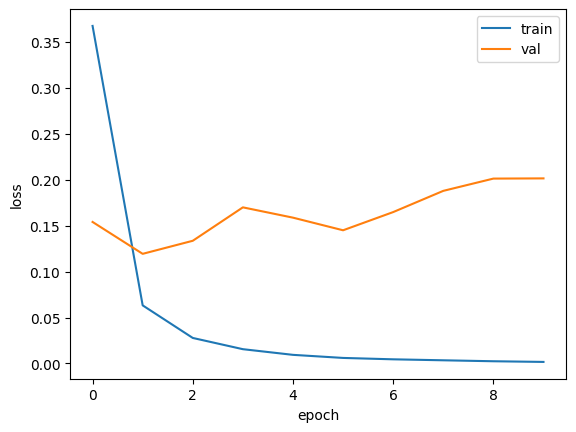

In [32]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

test

In [33]:
test_loss, test_acc = model3.evaluate(X_test, y_test_one_hot)
print('test_acc:', test_acc)

 13/125 [==>...........................] - ETA: 0s - loss: 0.2162 - accuracy: 0.9663    

125/125 [==============================] - 1s 5ms/step - loss: 0.2102 - accuracy: 0.9669
test_acc: 0.9668508172035217


In [34]:
preds = model3.predict(X_test)

125/125 [==============================] - 1s 5ms/step


confusion matrix에 적용

In [35]:
import numpy as np
labels=[0,1,2]
preds1 = [labels[np.argmax(probs)] for probs in preds]

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, preds1)

array([[1335,   23,   29],
       [   6, 1298,   46],
       [   8,   20, 1217]])

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds1))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1387
           1       0.97      0.96      0.96      1350
           2       0.94      0.98      0.96      1245

    accuracy                           0.97      3982
   macro avg       0.97      0.97      0.97      3982
weighted avg       0.97      0.97      0.97      3982

